# SCALE method

This notebook aims at evaluating the **SCALE method**.

**SCALE** method basically consists in re-using existing logit-based OOD methods, but with penultimate layer **activations scaled**. Let $a$ be the activation vector, and $P_p(a)$ the $p$-th percentile of $a$'s values. The scaling is computed using the formula
$$
s = \exp(\frac{\sum_{i} a_i}{\sum_{a_i > P_p(a)} a_i})
$$

Here, we focus on a Resnet trained on CIFAR10, challenged on SVHN.

**Reference**  
_Scaling for Training Time and Post-hoc Out-of-distribution Detection Enhancement_, ICLR 2024
<http://arxiv.org/abs/2310.00227>


### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from IPython.display import clear_output
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms

from oodeel.methods import MLS, Energy, ODIN, GEN
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features
from oodeel.datasets import load_data_handler
from oodeel.utils.torch_training_tools import train_torch_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Note that models are saved at *~/.oodeel/saved_models* and data is supposed to be found
at *~/.oodeel/datasets* by default. Change the following cell for a custom path.

In [2]:
model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

### Data loading

* In-distribution data: CIFAR-10 
* Out-of-distribution data: SVHN

> **Note:** We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD)
> data with `_out` to avoid confusion with OOD detection which is the name of the task,
> and is therefore used to denote the core class
> `OODBaseDetector`.

In [3]:
# === Load ID and OOD data ===
batch_size = 128

data_handler = load_data_handler("torch")

# 1a- Load in-distribution dataset: CIFAR-10
ds_in = data_handler.load_dataset(
    "CIFAR10", load_kwargs={"root": data_path, "train": False, "download": True}
)
# 1b- Load out-of-distribution dataset: SVHN
ds_out = data_handler.load_dataset(
    "SVHN", load_kwargs={"root": data_path, "split": "test", "download": True}
)


# 2- Prepare data (preprocess, shuffle, batch)
def preprocess_fn(inputs):
    """Preprocessing function from
    https://github.com/chenyaofo/pytorch-cifar-models
    """
    inputs["input"] = inputs["input"].float() / 255.0
    inputs["input"] = transforms.Normalize(
        (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
    )(inputs["input"])
    return inputs


ds_in = data_handler.prepare(
    ds_in, batch_size, preprocess_fn, columns=["input", "label"]
)
ds_out = data_handler.prepare(
    ds_out, batch_size, preprocess_fn, columns=["input", "label"]
)

clear_output()

### Model training

The model is a **DenseNet100** taken from the [Ash repo](https://github.com/andrijazz/ash), pretrained on Cifar10. You can download the checkpoints [here](https://www.dropbox.com/s/o5r3t3f0uiqdmpm/checkpoints.zip). Please note that the checkpoints are hosted by the Ash repo's owner, and we do not have control over their open availability.

We did not take a **ResNet20** like for other methods because the OOD results were disastrous on that model.

In [4]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(
            in_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.droprate = dropRate

    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        return torch.cat([x, out], 1)


class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BottleneckBlock, self).__init__()
        inter_planes = out_planes * 4
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(
            in_planes, inter_planes, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn2 = nn.BatchNorm2d(inter_planes)
        self.conv2 = nn.Conv2d(
            inter_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.droprate = dropRate

    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        out = self.conv2(self.relu(self.bn2(out)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return torch.cat([x, out], 1)


class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(
            in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.droprate = dropRate

    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return F.avg_pool2d(out, 2)


class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(
            block, in_planes, growth_rate, nb_layers, dropRate
        )

    def _make_layer(self, block, in_planes, growth_rate, nb_layers, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes + i * growth_rate, growth_rate, dropRate))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class DenseNet3(nn.Module):
    def __init__(
        self,
        depth,
        num_classes,
        growth_rate=12,
        reduction=0.5,
        bottleneck=True,
        dropRate=0.0,
    ):
        super(DenseNet3, self).__init__()
        in_planes = 2 * growth_rate
        n = (depth - 4) / 3
        if bottleneck == True:
            n = n / 2
            block = BottleneckBlock
        else:
            block = BasicBlock
        n = int(n)
        # 1st conv before any dense block
        self.conv1 = nn.Conv2d(
            3, in_planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        # 1st block
        self.block1 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes + n * growth_rate)
        self.trans1 = TransitionBlock(
            in_planes, int(math.floor(in_planes * reduction)), dropRate=dropRate
        )
        in_planes = int(math.floor(in_planes * reduction))
        # 2nd block
        self.block2 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes + n * growth_rate)
        self.trans2 = TransitionBlock(
            in_planes, int(math.floor(in_planes * reduction)), dropRate=dropRate
        )
        in_planes = int(math.floor(in_planes * reduction))
        # 3rd block
        self.block3 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes + n * growth_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(in_planes, num_classes)
        self.in_planes = in_planes

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2.0 / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.block1(out))
        out = self.trans2(self.block2(out))
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        # out = apply_ash(out, method=getattr(self, 'ash_method'))
        out = out.view(-1, self.in_planes)
        return self.fc(out)

Now we can instanciate the model, load the checkpoints and evaluate the model.

In [5]:
model = DenseNet3(100, 10)
model.load_state_dict(
    torch.load(
        model_path + "/densenet100_cifar10.pth",
        map_location=device,
    )
)

clear_output()

model = model.to(device)
model.eval()

# evaluate model
labels, preds = [], []
for x, y in ds_in:
    x = x.to(device)
    preds.append(torch.argmax(model(x), dim=-1).detach().cpu())
    labels.append(y)
print(f"Test accuracy:\t{accuracy_score(torch.cat(labels), torch.cat(preds)):.6f}")

Test accuracy:	0.945400


### SCALE scores

We now fit some OOD detectors using SCALE + [MLS, Energy, ODIN] with CIFAR10 train dataset, and compare OOD scores returned for CIFAR10 (ID) and SVHN (OOD) test datasets.


> **Warning:**
>
> - We recommend to manually set the parameter `head_layer_id` is the `.fit` to make sure that SCALE is applied before the classification head of the model. In that case, this layer's name is "`dense`"

=== ENERGY ===
~ With SCALE ~


auroc      0.960954
fpr95tpr   0.137000


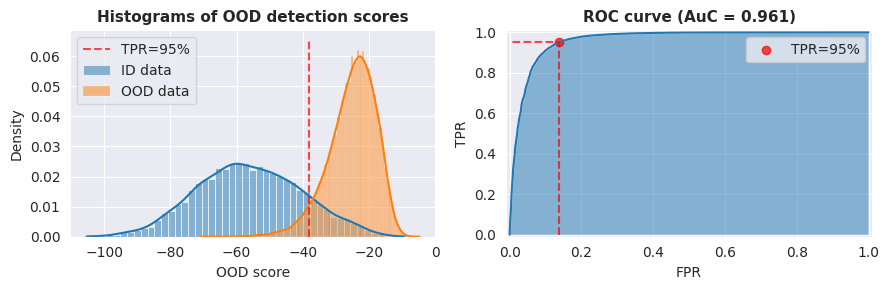

~ Without SCALE ~
auroc      0.941937
fpr95tpr   0.187800


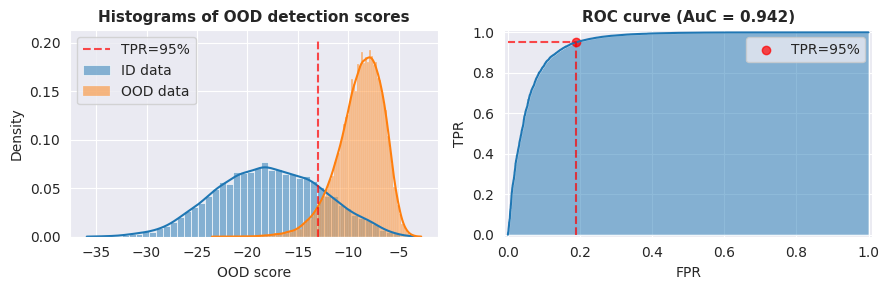

=== ODIN ===
~ With SCALE ~
auroc      0.955205
fpr95tpr   0.236900


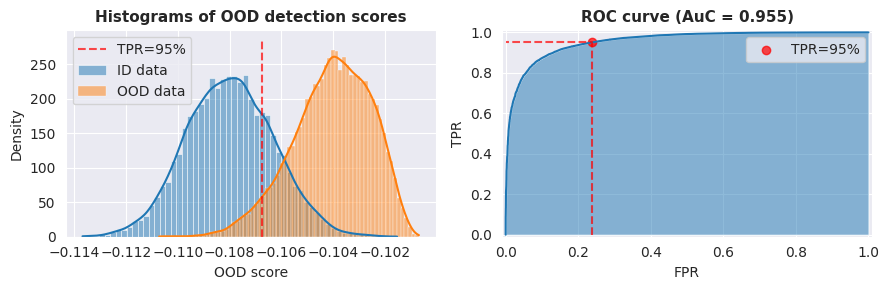

~ Without SCALE ~
auroc      0.944330
fpr95tpr   0.285000


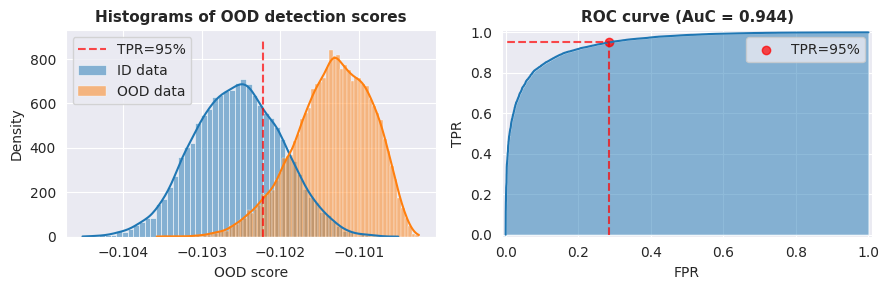

=== MLS ===
~ With SCALE ~
auroc      0.960959
fpr95tpr   0.137100


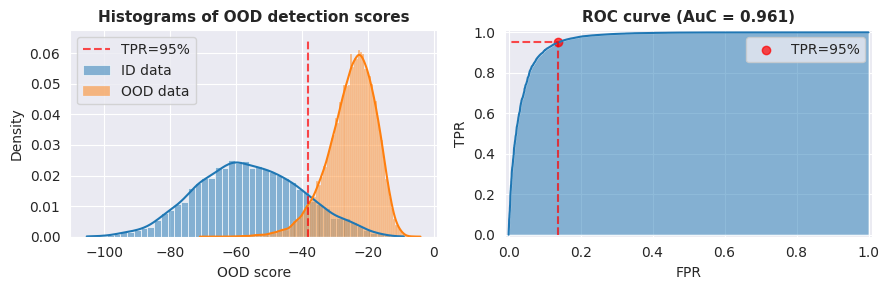

~ Without SCALE ~
auroc      0.943214
fpr95tpr   0.187000


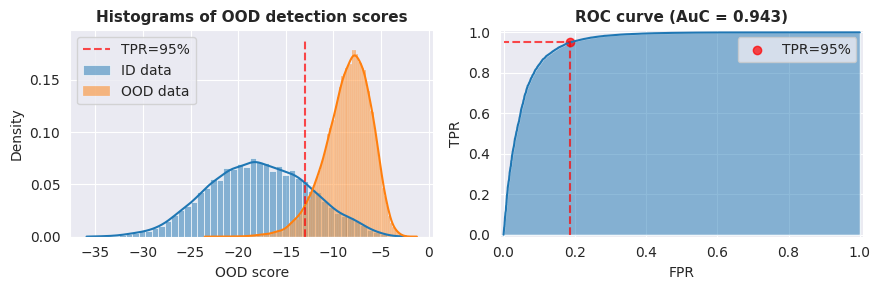

In [6]:
%autoreload 2

detectors = {
    "energy": {
        "class": Energy,
        "kwargs": dict(),
    },
    "odin": {
        "class": ODIN,
        "kwargs": dict(temperature=1000),
    },
    "mls": {
        "class": MLS,
        "kwargs": dict(),
    },
}

for d in detectors.keys():
    print(f"=== {d.upper()} ===")

    for use_scale in [True, False]:
        print(["~ Without", "~ With"][int(use_scale)] + " SCALE ~")
        # === ood scores ===
        d_kwargs = detectors[d]["kwargs"]
        d_kwargs.update(
            dict(
                use_scale=use_scale,
                scale_percentile=0.85,
            )
        )
        detector = detectors[d]["class"](**d_kwargs)
        detector.fit(model)
        scores_in, _ = detector.score(ds_in)
        scores_out, _ = detector.score(ds_out)

        # === metrics ===
        # auroc / fpr95
        metrics = bench_metrics(
            (scores_in, scores_out),
            metrics=["auroc", "fpr95tpr"],
        )
        for k, v in metrics.items():
            print(f"{k:<10} {v:.6f}")

        # hists / roc
        plt.figure(figsize=(9, 3))
        plt.subplot(121)
        plot_ood_scores(scores_in, scores_out)
        plt.subplot(122)
        plot_roc_curve(scores_in, scores_out)
        plt.tight_layout()
        plt.show()